#### Object Detection Using Neural Networks
This notebook uses the version of Faster R-CNN that uses a Resnet network as its backbone and also includes a  Feature Pyramid Network.

In [2]:
#Importing some improtant libraries that we will use wot wowrk with 
import numpy as np
import torch 
import torchvision
from torchvision import transforms as T
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn

#load model pre-trained on COCO
model = fasterrcnn_resnet50_fpn(pretrained =  True)

#this makes sure we are using the modle i inference mode
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## How to Load image
We can use the PIL library to easily load images 

In [4]:
# Loading Test image to run inference
test_img = Image.open("testimg1.jpg")
# converting image to Pytorch tensors to run inference
transform = T.ToTensor()
test_tensor = transform(test_img) 

In [5]:
# torch.no_grad() is used as we aren't training the model, just running an inference
with torch.no_grad():
    pred = model([test_tensor])


# What objects is the network looking for?
The Faster R-CNN model we are using in this notebook is contains a RESNET backbone which is trained on the Common Objects in Context (COCO) dataset. COCO contains over 330K images and 91 categories. Some example categories are "person", surfboard", "bottle" and "plates" etc. The full list of calss labels are sotred in the array coc_names

In [ ]:
# Function to draw bounding boxes around an image
def drawBoundingBoxLabels(img, bboxes, classLabels, threshold):
     

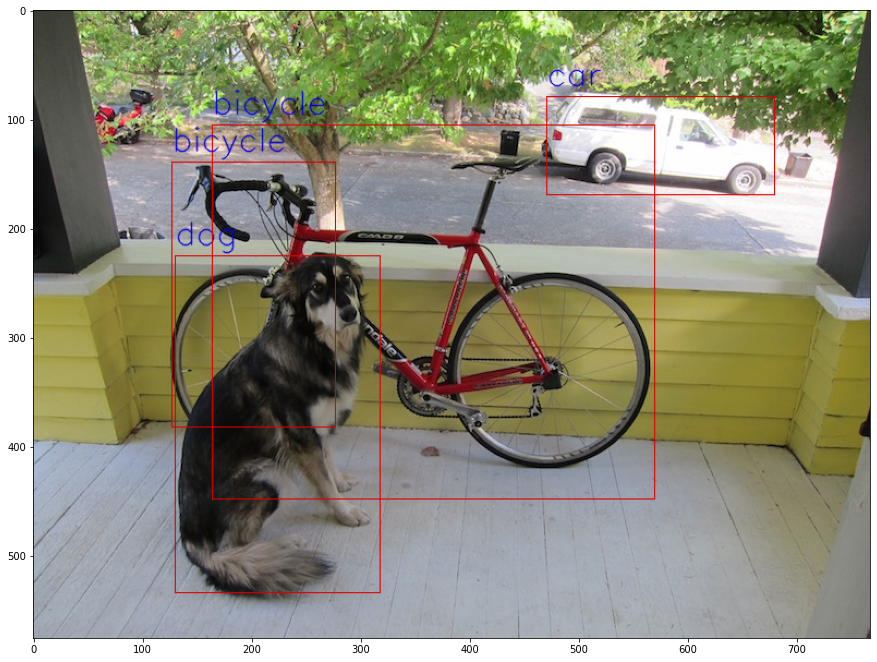

In [39]:
# Class labels that are predicted.
coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" ,"street sign" , "stop sign" ,
               "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" ,
                "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" , "frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" , "baseball glove" , 
                "skateboard" , "surfboard" , "tennis racket" , "bottle" , "plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" , "banana" , "apple" , "sandwich" ,
                "orange" , "broccoli" , "carrot" , "hot dog" ,"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,"mirror" , "dining table" , "window" , 
                "desk" , "toilet" , "door" , "tv" ,"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,"oven" , "toaster" , "sink" , "refrigerator" , 
                "blender" , "book" ,"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]

font = cv2.FONT_HERSHEY_SIMPLEX
bboxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]
bboxes = bboxes[scores >= 0.76]
labels = labels[scores >- 0.76]
scores = scores[scores >- 0.76]
igg = cv2.imread("testimg1.jpg")
igg = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)
for i in range(bboxes.shape[0]):
    box = bboxes[i]
    label = labels[i]
    class_name = coco_names[labels.numpy()[i]-1]
    igg = cv2.rectangle(igg,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (220, 0, 0), 1)
    igg = cv2.putText(igg, class_name, (int(box[0]), int(box[1]) -10), font, 1, (0,0,225), 1, cv2.LINE_AA)
plt.figure(figsize = (15,15))
plt.imshow(igg)

In [140]:
# Save image to folder
cv2.imwrite("detection1.PNG", igg)

True

In [14]:
## Obtain intermediate layer
outputs = []
model.eval()
hook = model.rpn.anchor_generator.register_forward_hook(
    lambda self, input, output: outputs.append(output))

with torch.no_grad():
    res = model([test_tensor])
hook.remove()

# Visualizing Anchor Boxes 
Below we will visualize 200 random anchor boxes what Faster R-CNN introduced.

Text(0.5, 1.0, '500 random Anchor boxes')

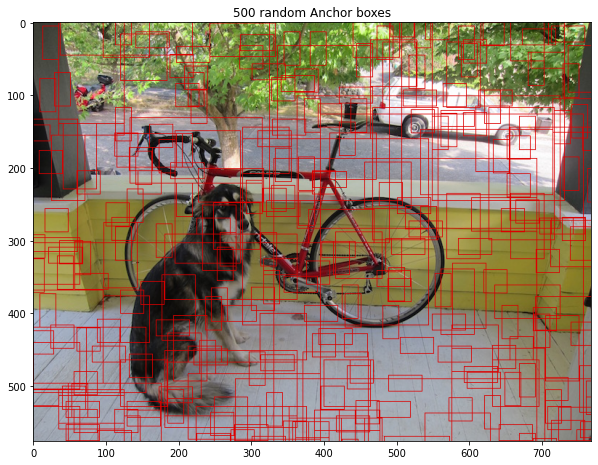

In [38]:
iggAnchor = cv2.imread("testimg1.jpg")
iggAnchor = cv2.cvtColor(iggAnchor, cv2.COLOR_BGR2RGB)
anchorBoxes = np.array(outputs[0][0])
randIdx = np.random.randint(0,anchorBoxes.shape[0], (500))

for i in randIdx:
    box = anchorBoxes[i,:]
    igg = cv2.rectangle(iggAnchor,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (220, 0, 0), 1)
plt.figure(figsize = (10,10))
plt.imshow(iggAnchor)
plt.title("500 random Anchor boxes")

In [47]:
## Obtain output of RPN layer
outputs = []
model.eval()
hook = model.rpn.head.cls_logits.register_forward_hook(
    lambda self, input, output: outputs.append(output))

with torch.no_grad():
    res = model([test_tensor])
hook.remove()

(1, 3, 100, 136)
